### В прошлый раз не получилось сделать дз до конца, в этот раз доделала, чтобы можно было сравнить результаты для hw2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import datetime
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss,roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV

Информация по датасету:

* date_time - время показа рекламы
* oaid_hash - хэш юзера
* zone_id - id зоны, где зона - место на сайте для размещения рекламы
* banner_id - id баннера, где баннер - сама реклама
* campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
* os_id - id операционной системы
* country_id - id страны
* banner_id0 - нулевой баннер в “стакане” баннеров
* banner_id1 - перый баннер в “стакане” баннеров
* rate0 - стоимость 1 клика установленная рекламодателем для banner_id0
* rate1 - стоимость 1 клика установленная рекламодателем для banner_id1
* g0 - стандартное отклонение предикта с banner_id0
* g1 - стандартное отклонение предикта с banner_id1
* coeff_sum0 - сумма коэффициентов для banner_id0
* coeff_sum1 - сумма коэффициентов для banner_id1
* impressions - был ли показ
* clicks - был ли клик


 колонки: oaid_hash, banner_id0, banner_id1, rate0, rate1, g0, g1, coeff_sum0, coeff_sum1 использовать не нужно

In [2]:
data = pd.read_csv('data.csv', parse_dates=['date_time'],infer_datetime_format=True)
columns_to_drop = ['oaid_hash', 'banner_id0','banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']
data.drop(columns_to_drop, axis=1, inplace = True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


# Анализ данных

In [3]:
def plot_bar(df,title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    for i, col in enumerate(df.columns):
        df[col].plot(kind='bar', ax=axes[i])
        axes[i].set_title(col)
    plt.tight_layout()
    fig.suptitle(title,y=1.05)
    plt.show()

In [4]:
def analysis(data: pd.DataFrame):
    font_size = "20px"
    text ='Описательные характеристики'
    print('\n')
    display(HTML(f"<p style='font-size: {font_size}'>{text}</p>"))

    print('\nЧисло пропусков в данных:')
    display(pd.DataFrame(data.isnull().sum()))

    print('\nЧисло уникальных значений в столбцах:')
    display(pd.DataFrame(data.nunique()))

    print('\nОписательные статистики:')
    display(data.describe())

    columns_for_plotting = ['zone_id','banner_id','campaign_clicks','os_id', 'country_id','impressions','clicks']

    print('\nМатрица корреляции:')
    fig, axes = plt.subplots(figsize=(7, 5))
    sns.heatmap(data.corr(),cmap='YlGnBu', annot=True)
    plt.show()

    print('\nАнализ дат:')
    ind = ['Различных лет','Различных месяцев','Различных дат']
    dat = [ data.date_time.dt.year.nunique(),data.date_time.dt.month.nunique(),data.date_time.dt.date.nunique()]
    display(pd.DataFrame(data=dat, index=ind))

    print('\nАнализ времени:')
    ind = ['Различных часов']
    dat = [ data.date_time.dt.hour.nunique()]
    display(pd.DataFrame(data=dat, index=ind))


    font_size = "20px"
    text ='Анализ распределения кликов'
    print('\n')
    display(HTML(f"<p style='font-size: {font_size}'>{text}</p>"))



    print('\nЧисло действий по датам:')

    display(pd.DataFrame(data.groupby(data['date_time'].dt.date)['clicks'].count()))

    clicks_by_day = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.date)['clicks']
    clicks_by_day['Число кликов'] = grouping.sum()
    clicks_by_day['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_day,'Число действий по датам')

    print('\nЧисло действий по дням недели:')
    display(pd.DataFrame(data.groupby(data['date_time'].dt.dayofweek)['clicks'].count()))


    clicks_by_month = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.dayofweek)['clicks']
    clicks_by_month['Число кликов'] = grouping.sum()
    clicks_by_month['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_month,'Число действий по дням недели')


    print('\nЧисло действий по месяцам:')
    display(pd.DataFrame(data.groupby(data['date_time'].dt.month)['clicks'].count()))


    clicks_by_month = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.month)['clicks']
    clicks_by_month['Число кликов'] = grouping.sum()
    clicks_by_month['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_month,'Число действий по месяцам')



    print('\nЧисло действий по часам:')
    display(pd.DataFrame(data.groupby(data['date_time'].dt.hour)['clicks'].count()))


    clicks_by_month = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.hour)['clicks']
    clicks_by_month['Число кликов'] = grouping.sum()
    clicks_by_month['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_month,'Число действий по месяцам')


Число пропусков в данных:


,0
date_time,0
zone_id,0
banner_id,0
campaign_clicks,0
os_id,0
country_id,0
impressions,0
clicks,0



Число уникальных значений в столбцах:


,0
date_time,604712
zone_id,3444
banner_id,1633
campaign_clicks,822
os_id,11
country_id,17
impressions,1
clicks,2



Описательные статистики:


,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00



Матрица корреляции:


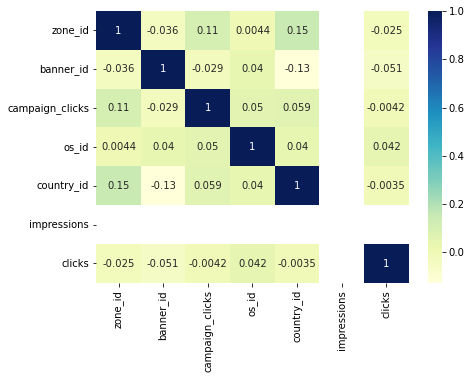


Анализ дат:


,0
Различных лет,1
Различных месяцев,2
Различных дат,8



Анализ времени:


,0
Различных часов,24



Число действий по датам:


,clicks
date_time,
2021-09-01,1
2021-09-26,3102610
2021-09-27,2367303
2021-09-28,2307355
2021-09-29,2420588
2021-09-30,1851189
2021-10-01,1643448
2021-10-02,2128978


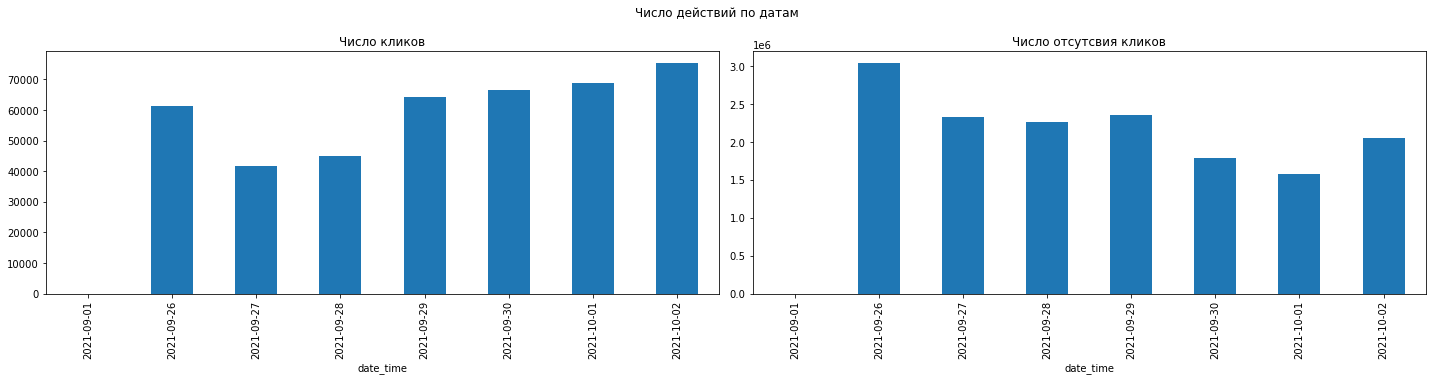


Число действий по дням недели:


,clicks
date_time,
0,2367303
1,2307355
2,2420589
3,1851189
4,1643448
5,2128978
6,3102610


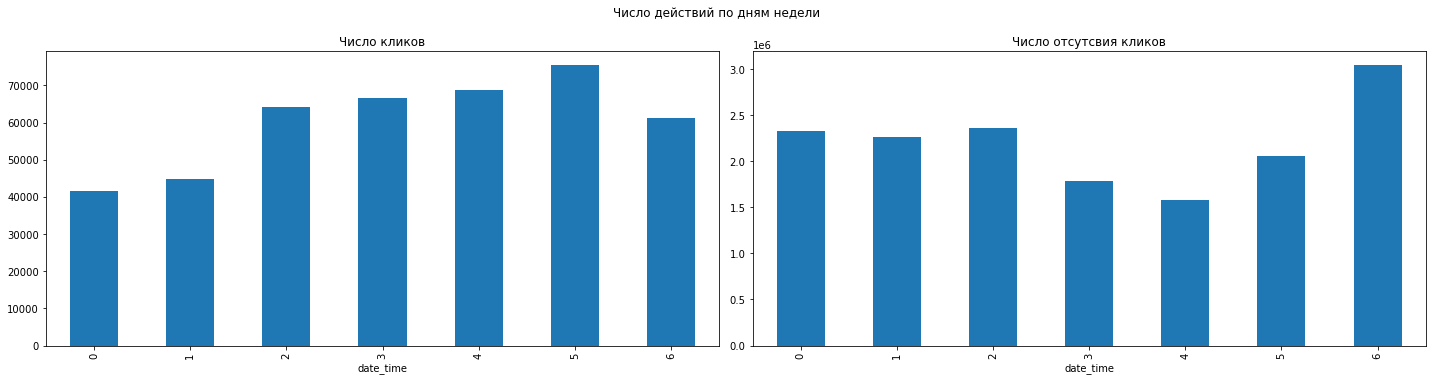


Число действий по месяцам:


,clicks
date_time,
9,12049046
10,3772426


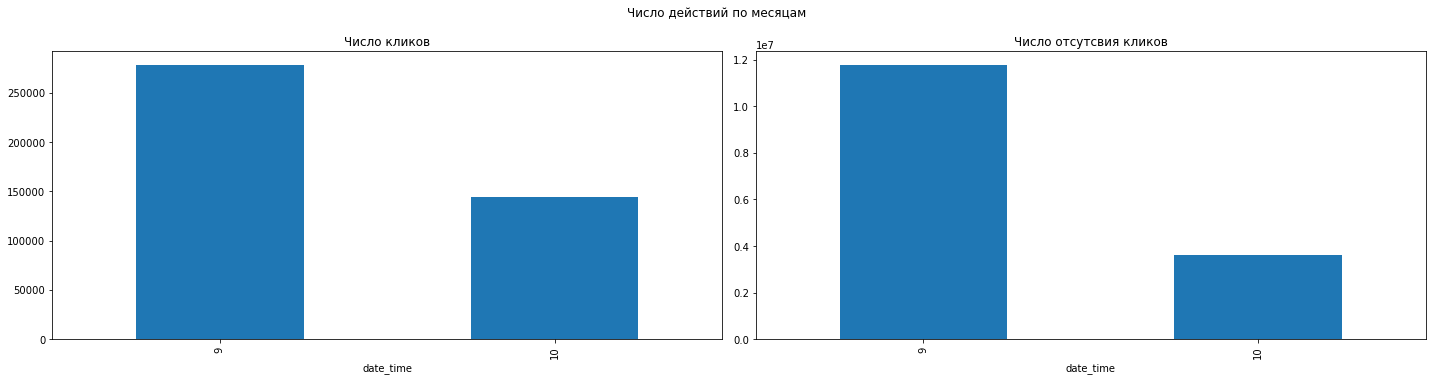


Число действий по часам:


,clicks
date_time,
0,550788
1,498533
2,482018
3,444033
4,405813
5,474251
6,476654
7,481859
8,547525


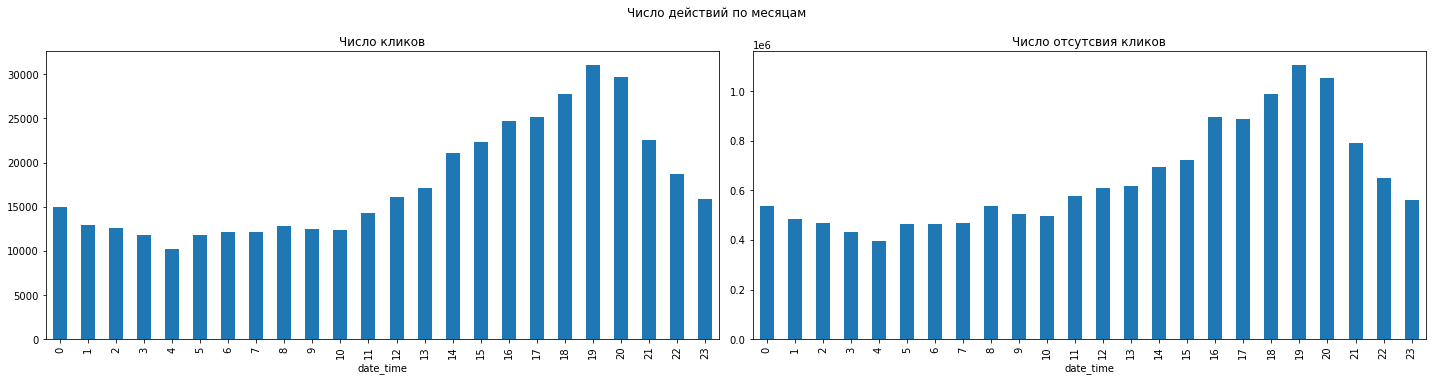

In [5]:
analysis(data)

## Итого мы имеем:
* все признаки, кроме campaign_clicks - категориальные
* между признаками нет сильной корреляции, что очень хорошо, тк нет необходимости убирать какие-то из них
* `impressions` всегда равняется 1, то есть показ всегда был, поэтому в дальнейшем можем убрать этот признак из анализа
* у нас имеется всего 8 дат, которые идут подряд, поэтому наверное выделение года и месяца особого смысла не имеет. Однако день недели может оказывать влияние на клики, поскольку можно предположить, что поведение в выходные дни может отличаться от рабочих.
* аналогично дню недели можно предположить что поведение пользователей в разное время дня может меняться, поэтому стоит его выделить.
* видно, что 01-09-2023 было совершено только одно действие, кажется можно его просто удалить


## Преобразование признаков

In [6]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # убираем из списка столбцов impressions
    data.drop(['impressions'], axis=1, inplace = True)
    # убираем дату с 1 действием
    data = data[~(data.date_time.dt.date == datetime.date(2021, 9, 1))]
    # выделяем дату
    data['date'] = data.date_time.dt.date
    # выделяем день недели
    data['day_of_week'] = data.date_time.dt.dayofweek
    # выделяем время дня
    data['hour'] = data.date_time.dt.hour
    # сгруппируем часы в промежутки дня утро, день, вечер, ночь (утро с 6 до 12, обед с 12 до 18, вечер с 18 до 24, ночь с 24 до 6)
    bins = [0, 6, 12, 18,  24]
    labels = ['Ночь', 'Утро', 'Обед', 'Вечер'] 
    data['time_of_day'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False)
    
    
    #Деление на train-test
    
    
    # выделяем последний день на test, все остальное на train
    train_data = data[(data.date < datetime.date(2021,10, 2))] 
    test_data = data[(data.date == datetime.date(2021,10, 2))] 
    
    x_feat_list = list(set(data.columns)- set(['clicks']))
    
    # выделяем категориальные признаки
    categ_feat = ['zone_id', 'banner_id', 'os_id', 'country_id', 'time_of_day', 'day_of_week']
    encoder = OneHotEncoder(drop='first', sparse=True)
    encoded_features = encoder.fit_transform(data[categ_feat])

    X_train = train_data[x_feat_list]
    X_enc = encoder.transform(X_train[categ_feat])
    X_train = hstack([X_train[['hour','day_of_week','campaign_clicks']].values,X_enc])
    y_train = train_data['clicks']

    X_test = test_data[x_feat_list]
    X_enc_test =  encoder.transform(X_test[categ_feat])
    X_test = hstack([X_test[['hour','day_of_week','campaign_clicks']].values,X_enc_test])
    y_test = test_data['clicks']
    
    return X_train,y_train,X_test,y_test

In [7]:
X_train,y_train,X_test,y_test = feature_engineering(data)

In [8]:
def create_model():
    return LogisticRegression(solver='liblinear', penalty='l2')

In [9]:
def cv():
    #подбираем параметры регуляризации
    c = {'C': [0.001, 0.01, 0.1, 1, 3]}
    model = create_model()
    gs = GridSearchCV(model, c, scoring=['neg_log_loss', 'roc_auc'], cv=5, verbose=2, refit='neg_log_loss')
    return gs

# Бейзлайн

In [10]:
y_pred_base = [y_train.mean()] * len(y_test)
print('Результаты бейзлайна:')
print("Log Loss:", log_loss(y_test, y_pred_base))
print("ROC AUC:", roc_auc_score(y_test, y_pred_base))

Результаты бейзлайна:
Log Loss: 0.15486197934508547
ROC AUC: 0.5


# Лучшая модель

In [11]:
gs = cv()
gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ............................................C=0.001; total time= 1.3min
[CV] END ............................................C=0.001; total time= 1.1min
[CV] END ............................................C=0.001; total time=  57.8s
[CV] END ............................................C=0.001; total time= 1.0min
[CV] END ............................................C=0.001; total time= 1.1min
[CV] END .............................................C=0.01; total time= 1.8min
[CV] END .............................................C=0.01; total time= 1.9min
[CV] END .............................................C=0.01; total time= 1.8min
[CV] END .............................................C=0.01; total time= 1.8min
[CV] END .............................................C=0.01; total time= 1.7min
[CV] END ..............................................C=0.1; total time= 3.2min
[CV] END ........................................

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 3]}, refit='neg_log_loss',
             scoring=['neg_log_loss', 'roc_auc'], verbose=2)

In [12]:
print("Лучший вариант параметра:", gs.best_params_)
best_model = gs.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]

Лучший вариант параметра: {'C': 1}


In [13]:
y_pred_base = [y_train.mean()] * len(y_test)
print('Результаты лучшей линейной модели:')
print("Log Loss:", log_loss(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Результаты лучшей линейной модели:
Log Loss: 0.13365635368945475
ROC AUC: 0.7791315815376957
